In [19]:
import pickle
with open('./hw1_data/LFW_DATA.pickle','rb') as f:
    data = pickle.load(f)
#print data.keys()
#[u'database_name', u'query_identity', u'database_identity', u'query_name', u'database_feature', u'query_feature']
src = data['database_feature']


In [17]:

with open('./hw1_data/lfw_attributes.txt') as f:
    ls = f.readlines()
print(ls[1])
at = ls[2:]
    

#	person	imagenum	Male	Asian	White	Black	Baby	Child	Youth	Middle Aged	Senior	Black Hair	Blond Hair	Brown Hair	Bald	No Eyewear	Eyeglasses	Sunglasses	Mustache	Smiling	Frowning	Chubby	Blurry	Harsh Lighting	Flash	Soft Lighting	Outdoor	Curly Hair	Wavy Hair	Straight Hair	Receding Hairline	Bangs	Sideburns	Fully Visible Forehead	Partially Visible Forehead	Obstructed Forehead	Bushy Eyebrows	Arched Eyebrows	Narrow Eyes	Eyes Open	Big Nose	Pointy Nose	Big Lips	Mouth Closed	Mouth Slightly Open	Mouth Wide Open	Teeth Not Visible	No Beard	Goatee	Round Jaw	Double Chin	Wearing Hat	Oval Face	Square Face	Round Face	Color Photo	Posed Photo	Attractive Man	Attractive Woman	Indian	Gray Hair	Bags Under Eyes	Heavy Makeup	Rosy Cheeks	Shiny Skin	Pale Skin	5 o' Clock Shadow	Strong Nose-Mouth Lines	Wearing Lipstick	Flushed Face	High Cheekbones	Brown Eyes	Wearing Earrings	Wearing Necktie	Wearing Necklace



In [52]:
# prepare dict for attributes with name
with open('./hw1_data/lfw_attributes.txt') as f:
    ls = f.readlines()
at = ls[2:]
attribute_dict = dict()
for l in at:
    atts = l.strip().split('\t')
#     print atts
    name,idx,male,asian,white = atts[0:5]
    if not attribute_dict.has_key(name):
        attribute_dict[name] = dict()
    attribute_dict[name][int(idx)] = float(male)

# missing attributes
file_names = data['database_identity'].ravel()
miss = 0
file_names = data['query_identity'].ravel()
for f in file_names:
    s = f[0].split('\\')[-1].split('.jpg')[0]
    idx = int(s.split('_')[-1])
    buf = s.replace('_',' ').split(' ')[:-1]
#     
    name = ''
    for b in buf:
        name += b
        name += ' '
    name = name.strip()
#         
    if not attribute_dict.has_key(name):
        print '[%s] not in dict.' % name
        miss += 1
    else:
        if not attribute_dict[name].has_key(idx):
            print '[%s][%d] index not in dict.' % (name, idx), attribute_dict[name].keys()
            miss+=1
#     print name, idx
print 'miss value ',miss
# print ids

[George W Bush][4] index not in dict. [1, 2, 3, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205, 206, 207, 208, 209, 210, 211, 212, 213, 214, 215, 216, 217, 218, 

In [30]:
import spams
import numpy as np
print(src.shape)
num = src.shape[0]
X = src.reshape([num, 80,59])

X = np.swapaxes(X,axis1=0,axis2=2)

lambda1 = [10**i for i in range(-6,-3,1)]
K = range(100,3200,400)
param = { 'K' : 400, # learns a dictionary with 100 elements
          'lambda1' : 10**-2, 'numThreads' : -1, 'mode':2,
          'iter' : 1000}

    
print(X.shape)




(13113, 4720)
(59, 80, 13113)


In [58]:
import spams
import numpy as np
import scipy
def train_SC(database, param, out_file='./dict.npy'):


    num = database.shape[0]
    X = database.reshape([num, 80,59])
    X = np.swapaxes(X,axis1=0,axis2=2)

    D_list = []
    pathces_num = X.shape[1]
#     for i in range(pathces_num):
    for i in range(1):
        x = np.asfortranarray(X[:,i,:])
        D = spams.trainDL(x,**param)
        D_list.append(D)
#     with open(out_file,'wb') as f:
#         np.save(f,D_list)
#     print('Done')
#     with open(out_file,'rb') as f:
#         data = np.load(f)
#     print(data.shape)
    return D_list
def sparse_coding(q_features, db_features, param):
    qs = q_features.reshape([len(q_features), 80,59])
    qs = np.swapaxes(qs,axis1=0,axis2=2)
    X = db_features.reshape([len(db_features), 80,59])
    X = np.swapaxes(X,axis1=0,axis2=2)
    
    D_list = train_SC(db_features, param)
    q_codeword = get_codeword(D_list, qs)
    db_codeword = get_codeword(D_list, X)
    
    return q_codeword, db_codeword
def get_codeword(D_list, X,lambda1=0.01):
    n = X.shape[-1]
    W = np.ones([60,n],dtype=float)
    W[:30] = float('inf')
    param = { 'lambda1' : lambda1,'numThreads' : -1, 'mode':2, 'W':np.asfortranarray(W)}
    buf = []
    pathces_num = len(D_list)
    for i in range(pathces_num):
        q = np.asfortranarray(X[:,i,:])
        D = D_list[i]
        print 'x', q.shape
        print 'd', D.shape
        print 'w', W.shape
        
        a = spams.lassoWeighted(q,D=D,**param)
        buf.append(a)
    buf = scipy.sparse.vstack(buf)
    codeword = np.zeros(buf.shape, dtype=np.bool)
    codeword[buf.nonzero()] = True
    
    
    codeword = np.swapaxes(codeword, axis1=0, axis2=1)
    
    return codeword
database = data['database_feature']
queries = data['query_feature']
labels = data['database_name'].ravel()
query_labels = data['query_name'].ravel()

#part 1: l2_distance and calculate_map
# mAP = calculate_map(database, labels, queries, query_labels, l2_distance)
# print(mAP)

#part 2: sparse_coding
pos = np.asfortranarray([3]*200)
param = { 'K' : 60,
                  'lambda1' : 0.01, 'numThreads' : -1, 'mode':2,
                  'iter' : 3}
        
q_sparse, db_sparse = sparse_coding(queries, database, param) #build sparse dict and lookup using spams library
# sparse_map = calculate_map(db_sparse, labels, q_sparse, query_labels, similarity_sparse_coding)# results_sparse = distance(q_sparse, db_sparse) #you can use l2_distance in part1 or try any distance metric, like cos, l1 

# sparse_coding(queries, database, param)
q = q_sparse[0,:]
print q.shape
print q
print 'Done'


x (59, 120)
d (59, 60)
w (60, 120)
x (59, 13113)
d (59, 60)
w (60, 13113)
(60,)
[False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False  True False False  True  True
 False False False  True False False False False False False False False
 False  True  True  True False False  True False  True False  True  True]
Done


In [3]:
import scipy
import scipy.spatial
import numpy as np
import spams
# print D
pathces_num = 80
test = data['query_feature']
num = test.shape[0]
qs = test.reshape([num, 80,59])
qs = np.swapaxes(qs,axis1=0,axis2=2)
# 
with open('./dict2.npy','rb') as f:
    D_list = np.load(f)
    D_list = [np.asfortranarray(D) for D in D_list]
def get_codeword(D_list, X,lambda1=0.01):
    
    param = { 'lambda1' : lambda1, 'lambda2' : 0,'numThreads' : -1, 'mode':2}
    buf = []
    for i in range(pathces_num):
        q = np.asfortranarray(X[:,i,:])
        D = D_list[i]
        a = spams.lasso(q,D=D,return_reg_path = False,**param)
        buf.append(a)
    buf = scipy.sparse.vstack(buf)
    codeword = np.zeros(buf.shape, dtype=np.bool)
    codeword[buf.nonzero()] = True
    return codeword

#
num = src.shape[0]
X = src.reshape([num, 80,59])

X = np.swapaxes(X,axis1=0,axis2=2)
print(X.shape)
# 
q_codeword = get_codeword(D_list, qs)
codeword = get_codeword(D_list, X)
print(q_codeword.shape)
print(codeword.shape)


(59, 80, 13113)
(32000, 120)
(32000, 13113)


In [6]:
import numpy as np
# from sklearn.metrics import average_precision_score

# 注意要計算and而不是xor(hamming distance)
def similarity_sparse_coding(codeword, query):
    q = query.ravel()
    
    distances = []
    for x in codeword:
#         distances.append(scipy.spatial.distance.hamming(x,query))
        distances.append(np.sum(np.logical_and(x,q)))
    return reversed(np.argsort(distances))


database = np.swapaxes(codeword, axis1=0, axis2=1)
labels = data['database_name'].ravel()

queries = np.swapaxes(q_codeword, axis1=0, axis2=1)
query_labels = data['query_name'].ravel()
print(database.shape, queries.shape)


import time
t1 = time.time()
calculate_map(database, labels, queries, query_labels, similarity_sparse_coding)
# mAP :  0.13721717999431532
# mAP : 0.1581216311119271 with 800
print('cost time : ', time.time() - t1)

(13113, 32000) (120, 32000)


NameError: name 'mAp' is not defined

In [ ]:
# inverted index for ranking
import threading
import numpy as np
# input : database[doc_num, word_dim]
# output : inverted_list[word_dim] each entry contains a list for docs index.
def generate_inverted_list(database, thread_count = 16):
    assert len(database.shape) == 2
    num, dim = database.shape
    print('generating inverted list with %d doc, %d interested words.' % (num, dim))
    inv_list = [[] for i in range(dim)]
    
    for idx,x in enumerate(database):
        for i,j in enumerate(x):
            if j == True:
                inverted_list[i].append(idx)
    return inv_list
#output : return an idx_list with decresing similarity which depends on occurrence count in inverted list
database = np.swapaxes(codeword, axis1=0, axis2=1)
print(database.shape)

import time
t1 = time.time()
inv_list = generate_inverted_list(database)
t2 = time.time()
print('takes : ', t2-t1)

    

(13113, 64000)
generating inverted list with 13113 doc, 64000 interested words.


In [77]:
import pickle

def rank_by_inverted_list(database, inverted_list, query):
    assert len(query.shape) == 1
    assert len(database.shape) == 2
    num, _ = database.shape
    count = [0] * num
    for i,j in enumerate(query):
        if j == True:
            for idx in inverted_list[i]:
                count[idx] += 1
    return reversed(np.argsort(count))
# print inv_list
database = np.swapaxes(codeword, axis1=0, axis2=1)
labels = data['database_name'].ravel()

queries = np.swapaxes(q_codeword, axis1=0, axis2=1)
query_labels = data['query_name'].ravel()

def similarity_with_inverted_list(codeword, query):
    return rank_by_inverted_list(codeword, inv_list, query)


calculate_map(database, labels, queries, query_labels, similarity_with_inverted_list)
# with open('inv_list.pickle','wb') as f:
#     pickle.dump(inv_list, f, protocol=2)


(13113, 32000) (120, 32000)
Done


In [4]:
from l2_distance import l2_distance #l2_distance.py
from sparse_coding import sparse_coding,similarity_sparse_coding #sparse_coding.py
from calculate_map import calculate_map #calculate_map.py
import pickle
lfw_path = './hw1_data/LFW_DATA.pickle'
with open(lfw_path, 'rb') as f:
    lfw = pickle.load(f)
database = lfw['database_feature']
queries = lfw['query_feature']
labels = lfw['database_name'].ravel()
query_labels = lfw['query_name'].ravel()

#part 1: l2_distance and calculate_map
# mAP = calculate_map(database, labels, queries, query_labels, l2_distance)
# print(mAP)

#part 2: sparse_coding
param = { 'K' : 400,
                  'lambda1' : 0.01, 'numThreads' : -1, 'mode':2,
                  'iter' : -10}
        
q_sparse, db_sparse = sparse_coding(lfw['query_feature'], lfw['database_feature'], param) #build sparse dict and lookup using spams library
sparse_map = calculate_map(db_sparse, labels, q_sparse, query_labels, similarity_sparse_coding)# results_sparse = distance(q_sparse, db_sparse) #you can use l2_distance in part1 or try any distance metric, like cos, l1 
print(sparse_map)
#part 3
lambda1 = [10**i for i in range(-6,-3,1)]
K = range(100,3200,400)
iter_ = -10
for k in K:
    for l1 in lambda1:
        

        param = { 'K' : k,
                  'lambda1' : l1, 'numThreads' : -1, 'mode':2,
                  'iter' : iter_}
        q_sparse, db_sparse = sparse_coding(lfw['query_feature'], lfw['database_feature'], param) #build sparse dict and lookup using spams library
        sparse_map = calculate_map(db_sparse, labels, q_sparse, query_labels, similarity_sparse_coding)# results_sparse = distance(q_sparse, db_sparse) #you can use l2_distance in part1 or try any distance metric, like cos, l1 

        print(k,l1, sparse_map)







train


In [6]:
sparse_map = calculate_map(db_sparse, labels, q_sparse, query_labels, similarity_sparse_coding)# results_sparse = distance(q_sparse, db_sparse) #you can use l2_distance in part1 or try any distance metric, like cos, l1 
print(sparse_map)


0.14895016188476712


In [12]:
# train for attributed
import pickle
import numpy as np
import sparse_coding

lfw_path = './hw1_data/LFW_DATA.pickle'
with open(lfw_path, 'rb') as f:
    lfw = pickle.load(f)
database = lfw['database_feature']

param = { 'K' : 200,
              'lambda1' : 0.01, 'numThreads' : -1, 'mode':2,
              'iter' : -10}


D_list = sparse_coding.train_SC(database, param)
sparse_coding.save_D_list(D_list, out_file='./dict200.npy')
    

KeyboardInterrupt: 

In [1]:
# load for attributed
import pickle
import numpy as np
lfw_path = './hw1_data/LFW_DATA.pickle'
with open(lfw_path, 'rb') as f:
    lfw = pickle.load(f)


In [102]:
import spams
import scipy

def load_D_list(in_file='./dict200.npy'):
    with open(in_file,'rb') as f:
        data = np.load(f)
    return data


def extract_name_idx_from_filename(s):
    s = s[0].split('\\')[-1].split('.jpg')[0]
    idx = int(s.split('_')[-1])
    buf = s.replace('_',' ').split(' ')[:-1]
    
    name = ''
    for b in buf:
        name += b
        name += ' '
    name = name.strip()
    return name, idx

def get_attribute_martix(features, identities, attribute_dict):
    X = np.zeros([ features.shape[0], 1])
    for i,f in enumerate(identities):
        name, idx = extract_name_idx_from_filename(f)
        value = 0
        if not attribute_dict.has_key(name):
            value = 0
        elif not attribute_dict[name].has_key(idx):
            value = 0
        else:
            value = attribute_dict[name][idx]
        X[i,0] = value
    return X

def get_weight_matrix(att, p=200, weight=float('inf'), var=120.):
#     W:  double p x n matrix   (weights)
    n = att.shape[0]
    W = np.ones([p,n])
    
#     ASC-D
#     for i,at in enumerate(att):
#         if at >= 0: # contain missing value
#             W[:p/2,i] = weight
#         else:
#             W[p/2:,i] = weight

#     ASC-W
    A = np.ones([p,])
    A[p/2:] = -1
    for i,at in enumerate(att):
        fa = np.repeat(at,p)
        assert fa.shape == (p, )
        W[:,i] = np.exp(np.abs(fa-A)/var)
    return np.asfortranarray(W)

def load_attribute_dict(path='./hw1_data/lfw_attributes.txt'):
    # prepare dict for attributes with name
    with open(path) as f:
        ls = f.readlines()
    at = ls[2:]
    attribute_dict = dict()
    for l in at:
        atts = l.strip().split('\t')
    #     print atts
        name,idx,male,asian,white = atts[0:5]
        if not attribute_dict.has_key(name):
            attribute_dict[name] = dict()
        attribute_dict[name][int(idx)] = float(white)
    return attribute_dict

def get_codeword(D_list, X, aX, lambda1=0.01, pathces_num=80):
    
    param = { 'lambda1' : lambda1, 'numThreads' : -1, 'mode':2}
    buf = []
    p = D_list.shape[-1]
    W = get_weight_matrix(aX,p)
    for i in range(pathces_num):
        q = np.asfortranarray(X[:,i,:])
        D = D_list[i]
        a = spams.lassoWeighted(q,D=np.asfortranarray(D),W=W,**param)
        buf.append(a)
    buf = scipy.sparse.vstack(buf)
    codeword = np.zeros(buf.shape, dtype=np.bool)
    codeword[buf.nonzero()] = True
    codeword = np.swapaxes(codeword, axis1=0, axis2=1)
    return codeword
def get_codeword2(D_list, X, aX, lambda1=0.01, pathces_num=80):
    
    param = { 'lambda1' : lambda1, 'numThreads' : -1, 'mode':2}
    buf = []
    for i in range(pathces_num):
        q = np.asfortranarray(X[:,i,:])
        D = D_list[i]
        a = spams.lasso(q,D=np.asfortranarray(D),**param)
        buf.append(a)
    buf = scipy.sparse.vstack(buf)
    codeword = np.zeros(buf.shape, dtype=np.bool)
    codeword[buf.nonzero()] = True
    codeword = np.swapaxes(codeword, axis1=0, axis2=1)
    return codeword

database = lfw['database_feature']
file_names = lfw['database_identity'].ravel()
q_database = lfw['query_feature']
q_file_names = lfw['query_identity'].ravel()

attribute_dict = load_attribute_dict(path='./hw1_data/lfw_attributes.txt')

aX = get_attribute_martix(database, file_names, attribute_dict)
qaX = get_attribute_martix(q_database, q_file_names, attribute_dict)
print 'qax',qaX.shape
D_list = load_D_list('./dict800.npy')

p = D_list.shape[-1]
print p
query = lfw['query_feature']
query = query.reshape([-1,80,59])
query = np.swapaxes(query, 0, 2)
train_X = database.reshape([-1,80,59])
train_X = np.swapaxes(train_X, 0, 2)
print query.shape
db_sparse = get_codeword2(D_list, train_X, aX)
print 'db done'
q_sparse = get_codeword2(D_list, query, qaX)
W = get_weight_matrix(qaX)
# print q_sparse.shape
# print W[90:110,0],q_sparse[0,:]

print db_sparse.shape, q_sparse.shape
print 'shape done'

qax (120, 1)


IOError: [Errno 2] No such file or directory: './dict800.npy'

In [95]:
from sparse_coding import sparse_coding,similarity_sparse_coding #sparse_coding.py
from calculate_map import calculate_map #calculate_map.py
labels = lfw['database_name'].ravel()
query_labels = lfw['query_name'].ravel()

sparse_map = calculate_map(db_sparse, labels, q_sparse, query_labels, similarity_sparse_coding)
print sparse_map
print 0.1589742172809806,'ASC-W white 800'
print 0.15933643322936533,'ASC-W white 400'
print 0.1537239903366804,'ASC-W white'
print 0.1380955609153339,'ASC-D male'
print 0.1532412851844244,'ASC-W male'
print 0.1523286780158036,'SC'
print 0.1581216311119271,'SC 400'
print 0.157690878436,'SC 800'



0.15933643322936533
0.158974217281 ASC-W white 800
0.157690878436 ASC-W white 400
0.153723990337 ASC-W white
0.138095560915 ASC-D male
0.153241285184 ASC-W male
0.152328678016 SC
0.158121631112 SC 800


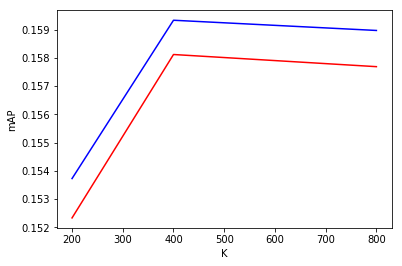

<module 'matplotlib.pyplot' from '/usr/local/lib/python2.7/dist-packages/matplotlib/pyplot.pyc'>

In [101]:
import numpy as np
import matplotlib.pyplot as plt
a = np.array([0.1537239903366804,0.15933643322936533,0.1589742172809806])
b = np.array([0.1523286780158036,0.1581216311119271,0.157690878436])
c = np.array([200,400,800])

plt.plot(c,a,'b-')
plt.plot(c,b,'r-')

plt.xlabel('K')
plt.ylabel('mAP')
plt.show()
plt
